In [1]:
# This notebook reproduces the plot of the gravitational potential in the DRMD paper / arXiv:2508.03795
# It also serves as an example run of the DRMD code using the bestfit cosmology for Planck 2018, DESI DR2, Pantheon+, SHOES

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy.fft import fft, ifft , rfft, irfft , fftfreq
from numpy import exp, log, log10, cos, sin, pi, cosh, sinh , sqrt
from classy import Class
from scipy import interpolate
import sys,os
from time import time
import json
import math
from scipy.interpolate import interp1d

import classy
print(classy.__version__)
print(classy.__file__)
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('text', usetex=True)
plt.rcParams["text.usetex"] = True

color_sequence = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

DRMD_c='blue'
SIDR_c='red'
LCDM_c='green'

fs=14
mode=0
mode2=1

kstr='0.05,0.002'

    

v3.2.5
/Users/florian/Documents/CMB/CLASS_env/CLASS/lib/python3.13/site-packages/classy.cpython-313-darwin.so


In [3]:
def read_in_bf(path, max_params=None):
    # Open file and manually read the first line (header)
    with open(path, "r") as f:
        header_line = f.readline().strip().lstrip("#")  # Remove "#" and whitespace
        data_line = f.readline().strip()  # Read the next line (numerical values)
    
    # Extract parameter names, removing commas and extra spaces
    keys = [k.strip().replace(',', '') for k in header_line.split()]
    
    # Extract values, converting them to float
    values = [float(v) for v in data_line.split()]
    
    # Apply max_params limit if specified
    if max_params is not None:
        keys = keys[:max_params]
        values = values[:max_params]
    
    # Construct the dictionary
    dict_res = {key: value for key, value in zip(keys, values)}
    
    print("BF DATA:", dict_res)
    return dict_res


def l_z(zvar, run):
    # Get background quantities
    bg = run.get_background()
    a_arr = 1 / (bg['z'] + 1)

    # Get z_rec from derived parameters
    z_rec = run.get_current_derived_parameters(['z_rec'])['z_rec']

    # Compute comoving distance to recombination
    # CLASS gives angular_distance in Mpc (proper angular diameter distance)
    D_star = run.angular_distance(z_rec) * (1 + z_rec)  # convert to comoving distance

    # Interpolate H(z) from CLASS background
    H_z = np.interp(1 / (zvar + 1), a_arr, bg['H [1/Mpc]'])

    # Horizon-scale mode: k = aH = H(z)/(1+z)
    k = H_z / (1 + zvar)

    # Angular multipole: ℓ ≈ k × D_star
    return [k * D_star,k]

def l_k(k,run):
    # Get background quantities
    bg = run.get_background()
    # Get z_rec from derived parameters
    z_rec = run.get_current_derived_parameters(['z_rec'])['z_rec']

    # Compute comoving distance to recombination
    # CLASS gives angular_distance in Mpc (proper angular diameter distance)
    D_star = run.angular_distance(z_rec) * (1 + z_rec)  # convert to comoving distance

    # Angular multipole: ℓ ≈ k × D_star
    return k * D_star


from scipy.optimize import brentq

def a_k(k_target, run):
    """
    Return the scale factor a_k when the comoving wavenumber k enters the horizon.
    Horizon-entry is defined as: k = aH(a)

    Parameters:
    -----------
    k_target : float
        Comoving wavenumber in 1/Mpc
    run : Class
        CLASS run instance (already computed)

    Returns:
    --------
    a_entry : float
        Scale factor when mode k enters the horizon
    """

    # Get background data
    bg = run.get_background()
    a_arr = 1 / (bg['z'] + 1)
    H_arr = bg['H [1/Mpc]']
    aH_arr = a_arr * H_arr

    # Create interpolator for aH(a)
    f_aH = interp1d(a_arr, aH_arr, kind='cubic', bounds_error=False, fill_value=np.nan)

    # Define function whose root gives the horizon-entry point
    def func_to_solve(a):
        return f_aH(a) - k_target

    # Find root: search interval should be within bg range
    a_min = a_arr[0]
    a_max = a_arr[-1]

    try:
        a_entry = brentq(func_to_solve, a_min, a_max)
    except ValueError:
        raise RuntimeError(f"No valid root found for k = {k_target} in a ∈ [{a_min}, {a_max}]")

    return a_entry

    
############################################







dict_general={
        'k_output_values':kstr,
        'output':'tCl,pCl,lCl,mPk',
        'lensing':'yes',
        'N_ur' : 2.0328,
        'N_ncdm' : 1,
        'm_ncdm' : 0.06,
        'T_ncdm' : 0.71611,
        'start_large_k_at_tau_h_over_tau_k': 0.00002,
        #'perturbations_verbose':'0',
        #'thermodynamics_verbose':'3',
        #'P_k_max_1/Mpc':1.0,
        'k_pivot':0.05,
        'P_k_max_1/Mpc':30.0,
        'z_max_pk': 4.,'l_switch_limber':9,
        #'non linear': 'hmcode',
    }

prefix='../'
name='DRMD'

DRMD_new_base_M_4p_bf = read_in_bf(prefix+name+'/'+'DRMD.bestfit',10)
dict_DRMD_new_base_M_4p = dict_general.copy()
dict_DRMD_new_base_M_4p.update(DRMD_new_base_M_4p_bf)

dict_DRMD_new_base_M_4p.update({"z_stop" :10**dict_DRMD_new_base_M_4p['log10z_stop']} )
dict_DRMD_new_base_M_4p.__delitem__('log10z_stop')

dict_DRMD_new_base_M_4p.update({"G_over_aH_drmd_ini" :10**dict_DRMD_new_base_M_4p['log10G/(aH)']} )
dict_DRMD_new_base_M_4p.__delitem__('log10G/(aH)')


BF DATA: {'omega_b': 0.02313339, 'omega_cdm': 0.1353455, 'h': 0.7288643, 'ln10^{10}A_s': 3.050024, 'n_s': 0.9783335, 'tau_reio': 0.06094734, 'delta_Neff_drmd': 0.8289278, 'log10z_stop': 4.825726, 'f_idm_drmd': 0.02854793, 'log10G/(aH)': 13.05733}


In [4]:
#LCDM run
name='DRMD'

LCDM_new_base_bf = read_in_bf(prefix+name+'/'+'LCDM.bestfit',6)
dict_LCDM_new_base = dict_general.copy()
dict_LCDM_new_base.update(LCDM_new_base_bf)

LCDM_new_base= Class()
LCDM_new_base.set(dict_LCDM_new_base)
LCDM_new_base.compute()

LCDM_new_base_derived=LCDM_new_base.get_current_derived_parameters(['z_dec_drmd','z_rec','H0','100*theta_s','rs_d','sigma8','Omega_m','z_eq'])
LCDM_new_base_bg = LCDM_new_base.get_background()
LCDM_new_base_pert = LCDM_new_base.get_perturbations()
z_rec_LCDM=LCDM_new_base_derived['z_rec']
z_eq_LCDM=LCDM_new_base_derived['z_eq']
z_dec_LCDM=LCDM_new_base_derived['z_dec_drmd']

a_LCDM=1/(LCDM_new_base_bg['z']+1)

LCDM_sarray = LCDM_new_base_pert['scalar']
LCDM_sdict = LCDM_sarray[0]
LCDM_sdict_2 = LCDM_sarray[1]
LCDMbase_a = LCDM_sdict['a'].copy()
LCDMbase_a2 = LCDM_sdict_2['a'].copy()
LCDM_Weyl=LCDM_sdict['phi']+LCDM_sdict['psi'].copy()
LCDM_Weyl2=LCDM_sdict_2['phi']+LCDM_sdict_2['psi'].copy()

klist=kstr.split(',')
ain2=a_k(float(klist[0]), LCDM_new_base)
ain1=a_k(float(klist[1]), LCDM_new_base)

Dstar_LCDM=LCDM_new_base.angular_distance(z_rec_LCDM)*(z_rec_LCDM+1) # Has to come last!



l2=float(klist[0]) *Dstar_LCDM*(1.+z_rec_LCDM)
l1=float(klist[1]) *Dstar_LCDM*(1.+z_rec_LCDM)


LCDM_new_base.struct_cleanup()



BF DATA: {'omega_b': 0.02242612, 'omega_cdm': 0.1192299, 'h': 0.6771166, 'ln10^{10}A_s': 3.048182, 'n_s': 0.9671182, 'tau_reio': 0.05671922}


In [5]:
# DRDMD run

DRMD_new_base_M_4p= Class()
DRMD_new_base_M_4p.set(dict_DRMD_new_base_M_4p)
DRMD_new_base_M_4p.compute()
DRMD_new_base_M_4p_derived=DRMD_new_base_M_4p.get_current_derived_parameters(['z_dec_drmd','z_rec','H0','100*theta_s','rs_d','sigma8','Omega_m'])
DRMD_new_base_M_4p_bg = DRMD_new_base_M_4p.get_background()
DRMD_new_base_M_4p_pert = DRMD_new_base_M_4p.get_perturbations()
z_rec_DRMD=DRMD_new_base_M_4p_derived['z_rec']
z_dec_DRMD=DRMD_new_base_M_4p_derived['z_dec_drmd']

a_DRMD=1/(DRMD_new_base_M_4p_bg['z']+1)

DRMD_sarray = DRMD_new_base_M_4p_pert['scalar']
DRMD_sdict = DRMD_sarray[0]
DRMD_sdict_2 = DRMD_sarray[1]
DRMDbase_a = DRMD_sdict['a'].copy()
DRMDbase_a2 = DRMD_sdict_2['a'].copy()
DRMD_Weyl=np.interp(LCDMbase_a,DRMDbase_a,DRMD_sdict['phi']+DRMD_sdict['psi']).copy()
DRMD_Weyl2=np.interp(LCDMbase_a2,DRMDbase_a2,DRMD_sdict_2['phi']+DRMD_sdict_2['psi']).copy()

klist=kstr.split(',')
ain2=a_k(float(klist[0]), DRMD_new_base_M_4p)
ain1=a_k(float(klist[1]), DRMD_new_base_M_4p)

Dstar_DRMD=DRMD_new_base_M_4p.angular_distance(z_rec_DRMD)*(z_rec_DRMD+1) # Has to come last!



l2=float(klist[0]) *Dstar_DRMD*(1.+z_rec_DRMD)
l1=float(klist[1]) *Dstar_DRMD*(1.+z_rec_DRMD)



DRMD_new_base_M_4p.struct_cleanup()



In [6]:
#Fiducial SIDR run (corresponding to DRMD with fidm=0)

dict_DRMD_new_base_M_4p_fidm=dict_DRMD_new_base_M_4p.copy()
dict_DRMD_new_base_M_4p_fidm.update({"f_idm_drmd" :0} )


DRMD_new_base_M_4p_fidm= Class()
DRMD_new_base_M_4p_fidm.set(dict_DRMD_new_base_M_4p_fidm)
DRMD_new_base_M_4p_fidm.compute()
DRMD_new_base_M_4p_fidm_derived=DRMD_new_base_M_4p_fidm.get_current_derived_parameters(['z_dec_drmd','z_rec','H0','100*theta_s','rs_d'])
DRMD_new_base_M_4p_pert_fidm = DRMD_new_base_M_4p_fidm.get_perturbations()

DRMD_sarray_fidm = DRMD_new_base_M_4p_pert_fidm['scalar']
DRMD_sdict_fidm = DRMD_sarray_fidm[0]
DRMD_sdict_fidm_2 = DRMD_sarray_fidm[1]
DRMDbase_fidm_a = DRMD_sdict_fidm['a'].copy()
DRMDbase_fidm_a2 = DRMD_sdict_fidm_2['a'].copy()
DRMD_Weyl_fidm=np.interp(LCDMbase_a,DRMDbase_fidm_a,DRMD_sdict_fidm['phi']+DRMD_sdict_fidm['psi']).copy()
DRMD_Weyl_fidm2=np.interp(LCDMbase_a2,DRMDbase_fidm_a2,DRMD_sdict_fidm_2['phi']+DRMD_sdict_fidm_2['psi']).copy()


DRMD_new_base_M_4p_fidm.struct_cleanup()

In [7]:
diff0=np.zeros(LCDMbase_a.shape)
diff0_2=np.zeros(LCDMbase_a2.shape)


diff1=DRMD_Weyl-LCDM_Weyl
diff1_2=DRMD_Weyl2-LCDM_Weyl2


diff2=DRMD_Weyl_fidm-LCDM_Weyl
diff2_2=DRMD_Weyl_fidm2-LCDM_Weyl2



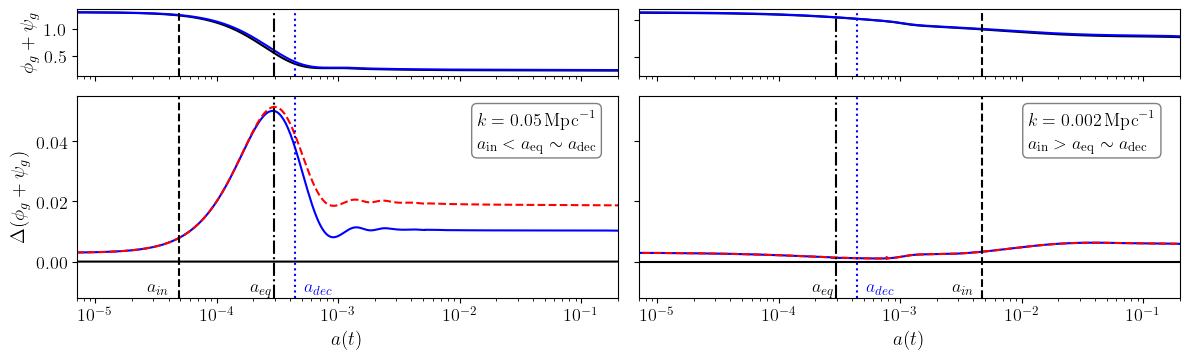

In [ ]:
import matplotlib.pyplot as plt


clcdm='black'
cSIDR='red'
cDRMD='blue'

fs = 14  # font size

# Set global figure size
#plt.rcParams['figure.figsize'] = [13, 4]
plt.rcParams['figure.figsize'] = [12, 3.7]

# Create subplot grid: 2 rows × 2 columns with height ratio 1:3
fig, axs = plt.subplots(nrows=2, ncols=2, gridspec_kw={'height_ratios': [1, 3]})
fig.subplots_adjust(hspace=0.0, wspace=0.05)

# Axes mapping
ax0, ax0b = axs[0]
ax1, ax2 = axs[1]

# Plot Weyl potentials (top row)
ax0.semilogx(LCDMbase_a2, LCDM_Weyl2, color=clcdm)
ax0.semilogx(LCDMbase_a2, DRMD_Weyl2, color=cDRMD)
ax0.axvline(x=1 / (z_dec_DRMD + 1), ls=':', c=cDRMD)
ax0.axvline(x=1 / (z_eq_LCDM + 1), ls='dashdot', c=clcdm)
ax0.axvline(x=ain2, ls='dashed', c=clcdm)
ax0.set_xlim(0.7e-5, 0.2)
ax0.set_xticklabels([])
ax0.set_ylabel(r'$\phi_g + \psi_g$', fontsize=fs)

ax0b.semilogx(LCDMbase_a, LCDM_Weyl, color=clcdm)
ax0b.semilogx(LCDMbase_a, DRMD_Weyl, color=cDRMD)
ax0b.axvline(x=1 / (z_dec_DRMD + 1), ls=':', c=cDRMD)
ax0b.axvline(x=1 / (z_eq_LCDM + 1), ls='dashdot', c=clcdm)
ax0b.axvline(x=ain1, ls='dashed', c=clcdm)
ax0b.set_xlim(0.7e-5, 0.2)
ax0b.set_xticklabels([])
ax0b.set_yticklabels([])

# Define labels
label0 = r'best fit $\Lambda$CDM (no SH$_0$ES prior)  '
label1 = r'best fit DRMD ($f_\mathrm{idm}>0$)'
label2 = r'fiducial SIDR ($f_\mathrm{idm}=0$)'


# Plot differences (bottom row, left)
ax1.semilogx(LCDMbase_a2, diff0_2, color='black', label=label0)
ax1.semilogx(LCDMbase_a2, diff1_2, color=cDRMD, label=label1)
ax1.semilogx(LCDMbase_a2, diff2_2, color=cSIDR, label=label2,ls='--')


ax1.axvline(x=1 / (z_dec_DRMD + 1), ls=':', c=cDRMD)
ax1.axvline(x=1 / (z_eq_LCDM + 1), ls='dashdot', c=clcdm)
ax1.axvline(x=ain2, ls='dashed', c=clcdm)
ax1.set_xlim(0.7e-5, 0.2)
ax1.set_ylim(-0.012, 0.055)
ax1.set_xlabel(r"$a(t)$", fontsize=fs)
ax1.set_ylabel(r'$\Delta (\phi_g + \psi_g)$', fontsize=fs)


# Plot differences (bottom row, right)
ax2.semilogx(LCDMbase_a, diff0, color=clcdm, label=label0)
ax2.semilogx(LCDMbase_a, diff1, color=cDRMD, label=label1)
ax2.semilogx(LCDMbase_a, diff2, color=cSIDR, label=label2,ls='--')


ax2.axvline(x=1 / (z_dec_DRMD + 1), ls=':', c=cDRMD)
ax2.axvline(x=1 / (z_eq_LCDM + 1), ls='dashdot', c=clcdm)
ax2.axvline(x=ain1, ls='dashed', c=clcdm)
ax2.set_xlim(0.7e-5, 0.2)
ax2.set_ylim(-0.012, 0.055)
ax2.set_xlabel(r"$a(t)$", fontsize=fs)
ax2.set_yticklabels([])

# Tick label fonts
for ax in [ax0, ax1, ax2]:
    plt.setp(ax.get_yticklabels(), fontsize=13)
for ax in [ax1, ax2]:
    plt.setp(ax.get_xticklabels(), fontsize=13)

# Annotations (text inside bottom plots)
ax1.text(0.32, 0.03, r'$a_{eq}$', transform=ax1.transAxes, fontsize=13)
ax1.text(0.42, 0.03, r'$a_{dec}$', transform=ax1.transAxes, fontsize=13,c=cDRMD)
ax1.text(0.13, 0.03, r'$a_{in}$', transform=ax1.transAxes, fontsize=13)

ax2.text(0.32, 0.03, r'$a_{eq}$', transform=ax2.transAxes, fontsize=13)
ax2.text(0.42, 0.03, r'$a_{dec}$', transform=ax2.transAxes, fontsize=13,c=cDRMD)
ax2.text(0.58, 0.03, r'$a_{in}$', transform=ax2.transAxes, fontsize=13)


# --- Parse k-modes ---
kstr = '0.05,0.002'
klist = kstr.split(',')

# --- Common text box style ---
props = dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=1)

# --- Text for ax1 (left) ---
ax1.text(
    0.74, .72,
    r"$\begin{array}{l} k = " + klist[0] + r"\,\mathrm{Mpc}^{-1} \\ a_{\rm in} < a_{\rm eq} \sim a_{\rm dec} \end{array}$",
    transform=ax1.transAxes, fontsize=13, bbox=props, verticalalignment='bottom'
)

# --- Text for ax2 (right) ---
ax2.text(
    0.72, .72,
    r"$\begin{array}{l} k = " + klist[1] + r"\,\mathrm{Mpc}^{-1} \\ a_{\rm in} > a_{\rm eq} \sim a_{\rm dec} \end{array}$",
    transform=ax2.transAxes, fontsize=13, bbox=props, verticalalignment='bottom'
)
# Tight layout and save
plt.tight_layout()
plt.show()
plt.close('all')


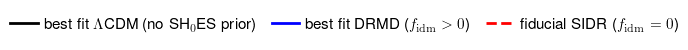

In [9]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


legend_elements = [
    Line2D([0], [0], color=clcdm, lw=2, label=label0),
    Line2D([0], [0], color=cDRMD, lw=2, label=label1),
    Line2D([0], [0], color=cSIDR, lw=2, ls='--', label=label2)
]


fig = plt.figure(figsize=(6.5, 0.4))  
ax = fig.add_subplot(111)
ax.axis('off')

# Legend
legend = ax.legend(
    handles=legend_elements,
    loc='center',
    ncol=3,
    frameon=False,
    fontsize=11,
    handletextpad=0.4,
    columnspacing=1.0,
    borderpad=0.0,        
    handlelength=1.8
)

plt.show()
plt.close(fig)
